In [26]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib as mpl
import matplotlib.pyplot as plt

train_path = "res/amazonReviews.800.train.csv"
test_path = "res/amazonReviews.700.test.csv"
result_folder = "results/"

test_set_ratio = 0.1 

In [5]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train.head(10)

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,545,5,4,3,2,2,3,1,1,2,...,0,0,0,0,0,0,0,1,0,Engineer
1,800,14,3,2,5,1,1,1,5,0,...,0,0,1,0,0,0,1,1,0,Kolln
2,1390,14,7,4,4,3,3,4,5,2,...,0,0,0,0,0,0,1,0,0,Vernon
3,1161,23,10,7,9,8,1,7,3,1,...,0,0,0,0,0,0,0,0,0,Nigam
4,23,13,3,3,6,1,5,0,3,3,...,0,0,0,0,1,0,0,1,0,Agresti
5,1386,11,16,7,9,9,6,0,2,2,...,0,0,0,0,0,0,1,0,0,Vernon
6,766,12,1,5,6,6,6,2,3,3,...,0,0,0,0,0,0,0,0,0,Koenig
7,1348,11,14,5,8,4,8,7,4,1,...,0,0,0,0,0,1,0,0,0,Sherwin
8,475,6,9,2,3,6,2,6,1,1,...,0,0,1,0,0,0,1,0,0,Cutey
9,132,1,2,6,0,0,0,8,1,2,...,0,0,0,0,0,0,0,0,0,Brody


### Initialize Training data

In [22]:
df_vars = df_train.loc[:, df_train.columns != 'Class']
df_class = df_train['Class']

X_train, X_test, y_train, y_test = train_test_split(df_vars, df_class, test_size=test_set_ratio, random_state=0)
clf = DecisionTreeClassifier(criterion="gini", max_depth=15, random_state=13221323)

### Simple cross validation for well-founded results

In [25]:
scores = cross_validate(clf, df_vars, df_class, cv=5)
scores['test_score'].mean()

# dt criterion=gini
# array([0.93854749, 0.9408284 , 0.93125   , 0.90728477, 0.96453901])
# dt criterion = entropy
# array([0.9273743 , 0.90532544, 0.91875   , 0.92715232, 0.95744681])

0.9151947689446625

### Hyper-parameter tuning

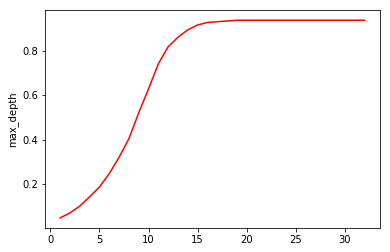

In [30]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
results = []
for max_depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=13221323)
    scores = cross_validate(clf, df_vars, df_class, cv=5)
    results.append(scores['test_score'].mean())
    
plt.plot(max_depths, results, "r", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("max_depth")
plt.show()

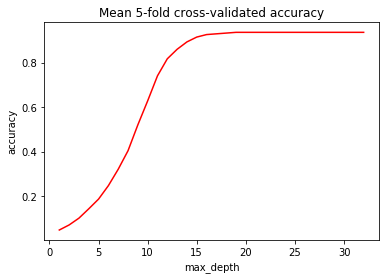

In [32]:
plt.plot(max_depths, results, "r", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("max_depth")
plt.title("Mean 5-fold cross-validated accuracy")
plt.show()

In [29]:
results

[0.04754049078341911,
 0.07027344270035563,
 0.10082085394899495,
 0.14282832372373164,
 0.1865830563550845,
 0.24702044504538573,
 0.32066515511840044,
 0.40410762857270627,
 0.5202781244466426,
 0.6282492375418527,
 0.7408054019871607,
 0.817475578657889,
 0.8602347521466868,
 0.8934476194445787,
 0.9151947689446625,
 0.9264340668191128,
 0.9297860221263754,
 0.9331379774336378,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004,
 0.9364899327409004]

### Model fitting and sample testing

In [24]:
model = clf.fit(X_train, y_train)
model.score(X_test, y_test)

0.975

### Final prediction

In [13]:
df_res = pd.DataFrame()
df_res['ID'] = df_test['ID']
df_res['class'] = pd.Series(model.predict(df_test))
df_res.head(10)

,ID,class
0,656,Grove
1,949,Mark
2,255,CFH
3,21,Agresti
4,1412,Vision
5,278,Chachra
6,81,Auken
7,1475,Wilson
8,955,Mark
9,1400,Vernon


### Export

In [15]:
export_file_name = result_folder + "simple_dt_entropy.csv"
df_res.to_csv(export_file_name, index=False)